In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats


In [2]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
#xclbin='/data/craco/ban115/builds/binary_container_01482863.xclbin'
alloc_device_only=True

In [3]:
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [4]:
device = pyxrt.device(1)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)


In [5]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --ndout 186")

parsing values --ndm 2 --ndout 186


In [6]:
print(plan.ndout)

186


In [7]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allo

In [8]:
p.clear_buffers(values)
# dmamp = 32 gives SNR=14.2
dmamp = 32
t0 = 0

# put in a value for a single time and DM
for b in p.all_mainbufs:
    print(b.shape)
    #b.nparr[:] = dmamp #np.random.randn(*b.nparr.shape)
    #b.nparr[:] = dmamp
    b.nparr[:,:,:,t0,:,0] = dmamp
    b.copy_to_device() 

[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]


In [9]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)
347787264


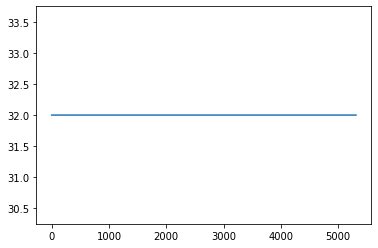

In [10]:
print(mainbuf.shape)
plot(mainbuf[:,0,0,t0,:,0].flat)
assert np.all(mainbuf[:,0,0,t0,:,0] == dmamp)
assert np.all(mainbuf[:,1:,1:,:t0,:,1] == 0)
assert np.all(mainbuf[:,1:,1:,:t0+1,:,1] == 0)
print(mainbuf.sum())

In [11]:
values.run_fdmt = False
values.run_image = True
values.threshold = 3
print(values)
p.run(0, values).wait()

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=False, run_image=True, show=False, show_candidate_grid=None, threshold=3, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [12]:
cands = p.get_candidates()
print(f'Got {len(cands)} candidates')
if len(cands) == 0: # are you sure?
    p.candidates.copy_from_device()
    print(p.candidates.nparr)
    
print_candidates(cands, 256, 0)

Got 298 candidates
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
3.0	162	129	0		1	0	0
34.9	127	129	0		0	0	0
5.6	138	130	0		0	0	0
5.2	122	130	0		0	0	0
8.0	135	131	0		1	0	0
3.3	105	131	0		0	0	0
5.0	120	131	0		1	0	0
5.2	134	132	1		1	0	0
7.9	124	132	0		0	0	0
8.0	133	133	0		0	0	0
3.5	102	133	0		1	0	0
4.5	123	133	0		0	0	0
6.8	134	134	0		0	0	0
5.2	117	134	0		1	0	0
8.0	131	135	0		1	0	0
3.6	147	135	0		0	0	0
5.6	116	135	0		1	0	0
6.5	136	136	1		1	0	0
3.9	110	136	0		0	0	0
5.2	126	136	1		1	0	0
5.0	131	137	0		0	0	0
3.4	179	137	0		0	0	0
3.3	111	137	1		1	0	0
4.5	118	137	0		1	0	0
5.6	130	138	0		0	0	0
3.4	178	138	1		1	0	0
3.9	108	138	1		1	0	0
4.8	117	138	0		1	0	0
4.5	131	139	0		0	0	0
3.5	181	139	0		1	0	0
3.8	107	139	0		1	0	0
4.6	121	139	0		0	0	0
4.4	122	140	1		1	0	0
3.4	101	141	0		0	0	0
6.1	121	141	1		1	0	0
4.3	100	142	0		0	0	0
6.6	120	142	1		1	0	0
3.7	99	143	1		1	0	0
3.9	119	143	0		0	0	0
3.8	96	144	0		0	0	0
3.1	71	145	0		0	0	0
4.7	95	145	1		1

In [13]:
print(cands)
cands = cands[cands['dm'] == 0] # DM 0 adn 1 are repeated, I think.

[(5342,     0, 0, 0, 0) (1052,   255, 0, 1, 0) ( 734,   257, 1, 1, 0)
 ( 193,   290, 0, 1, 0) (2236,   511, 0, 0, 0) ( 356,   522, 0, 0, 0)
 ( 331,   762, 0, 0, 0) ( 514,   775, 0, 1, 0) ( 213,  1001, 0, 0, 0)
 ( 320,  1016, 0, 1, 0) ( 332,  1030, 1, 1, 0) ( 507,  1276, 0, 0, 0)
 ( 512,  1285, 0, 0, 0) ( 223,  1510, 0, 1, 0) ( 290,  1531, 0, 0, 0)
 ( 437,  1542, 0, 0, 0) ( 336,  1781, 0, 1, 0) ( 509,  1795, 0, 1, 0)
 ( 228,  1811, 0, 0, 0) ( 360,  2036, 0, 1, 0) ( 416,  2056, 1, 1, 0)
 ( 251,  2286, 0, 0, 0) ( 331,  2302, 1, 1, 0) ( 319,  2307, 0, 0, 0)
 ( 218,  2355, 0, 0, 0) ( 213,  2543, 1, 1, 0) ( 288,  2550, 0, 1, 0)
 ( 359,  2562, 0, 0, 0) ( 217,  2610, 1, 1, 0) ( 251,  2796, 1, 1, 0)
 ( 305,  2805, 0, 1, 0) ( 291,  2819, 0, 0, 0) ( 221,  2869, 0, 1, 0)
 ( 241,  3051, 0, 1, 0) ( 293,  3065, 0, 0, 0) ( 279,  3322, 1, 1, 0)
 ( 220,  3557, 0, 0, 0) ( 392,  3577, 1, 1, 0) ( 278,  3812, 0, 0, 0)
 ( 422,  3832, 1, 1, 0) ( 238,  4067, 1, 1, 0) ( 251,  4087, 0, 0, 0)
 ( 243,  4320, 0, 0,

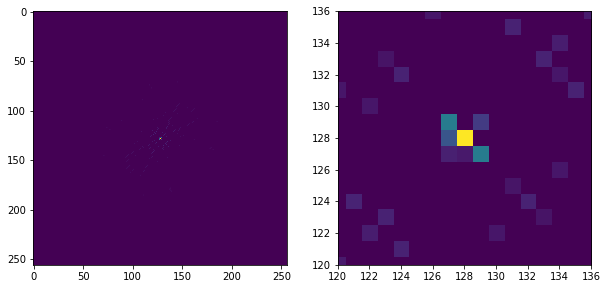

In [14]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

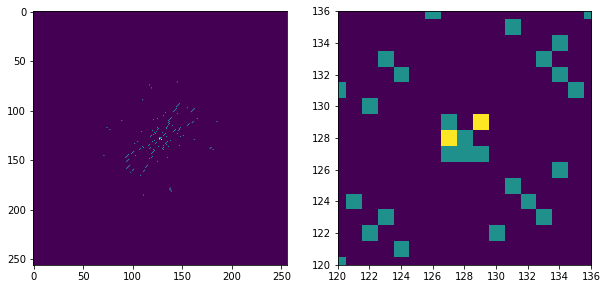

In [15]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

# Check DM0 for trange makes sense

In [ ]:
all_cands = []
for t0 in range(16):
    p.clear_buffers(values)
    # dmamp = 32 gives SNR=14.2
    dmamp = 32
    print('t0', t0)

    # put in a value for a single time and DM
    for b in p.all_mainbufs:
        b.nparr[:] = 0
        b.nparr[:,:,:,t0,:,0] = dmamp
        b.copy_to_device()

    values.run_fdmt = False
    values.run_image = True
    values.threshold = 10
    p.run(0, values).wait()
    cands = p.get_candidates().copy()
    all_cands.append(cands)
    c0 = cands[0]
    print(c0)
    #assert c0['upix'] == 128
    #assert c0['vpix'] == 128
    #assert c0['boxc_width'] == 0
    #assert c0['time'] == t0
    #assert c0['dm'] == 0
    print_candidates(cands, 256, 0)

    

t0 0
(5342, 0, 0, 0, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
34.9	127	129	0		0	0	0
34.9	129	127	0		0	0	0
83.5	128	128	0		0	1	0
16.4	127	128	0		1	1	0
11.5	129	129	1		1	1	0
34.9	127	129	0		0	1	0
34.9	129	127	0		0	1	0
t0 1
(5342, 0, 0, 1, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		1	0	0
16.4	128	129	0		0	0	0
34.9	127	129	0		1	0	0
34.9	129	127	0		1	0	0
11.5	127	127	1		1	0	0
28.7	128	128	7		8	0	0
12.0	127	129	7		8	0	0
12.0	129	127	7		8	0	0
83.5	128	128	0		1	1	0
16.4	128	129	0		0	1	0
34.9	127	129	0		1	1	0
34.9	129	127	0		1	1	0
11.5	127	127	1		1	1	0
28.7	128	128	7		8	1	0
12.0	127	129	7		8	1	0
12.0	129	127	7		8	1	0
t0 2
(5342, 0, 0, 2, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		2	0	0
16.4	127	128	0		3	0	0
11.5	129	129	1		3	0	0
34.9	127	129	0		2	0	0
34.9	129	127	0		2	0	0
31.3	128	128	6		8	0	0
13.1	127	129	6		8	0	0
13.1	129	127	6		8	0	0
83.5	128	128	0		2	1	0
16.4	127	128	0		3	1	0
11.5	129	129	

In [ ]:
for c in all_cands:
    print_candidates(c, 256, 0)

# FDMT the input of DM=0

In [ ]:
all_cands = []
t0 = 0
print(p.inbuf.shape)

values.run_fdmt = True
values.run_image = True
values.threshold = 10
p.clear_buffers(values)
p.inbuf.nparr[:,t0,:,:,0] = 1
p.inbuf.copy_to_device()

print('t0', t0)

p.run(0, values).wait()
cands = p.get_candidates().copy()
all_cands.append(cands)
print_candidates(cands, 256, 0)


In [ ]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
mainbuf = p.copy_mainbuf()

In [ ]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

In [ ]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

In [ ]:
plot(d[:, 0])
 # Oh yeah, OK, this makes sense. It's 32 for all baselines because I made every UV = 1. IN practice, it won't be that neat.

# And what if I grid everything properly?

In [ ]:
print(plan.baseline_shape) # nbl, nc, nt
values.input_scale = 1./16. # need this otherwise somewhere candidates overflow.

In [ ]:
din = np.zeros(plan.baseline_shape, dtype=np.complex64)
din[:, :, 0] = 1 # making this 32 overflows the FDMT


In [ ]:
import craft.craco
fast_baseline2uv = craft.craco.FastBaseline2Uv(plan, conjugate_lower_uvs=True)
uv_shape     = (plan.nuvrest, plan.nt, plan.ncin, plan.nuvwide)
uv_out  = np.zeros(uv_shape, dtype=np.complex64)
fast_baseline2uv(din, uv_out)

In [ ]:
print(uv_out.shape)

In [ ]:
p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
print(p.inbuf.nparr.mean())

In [ ]:
p.inbuf.copy_to_device()

In [ ]:
p.run(0, values).wait()

In [ ]:
mainbuf = p.copy_mainbuf()

In [ ]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

In [ ]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

In [ ]:
plot(d[:, 0])
# OK so this crazy shape is because of how we're inefficiently packing channels into UV points

In [ ]:
cands = p.get_candidates()
print(len(cands))

In [ ]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [ ]:
print_candidates(cands, 256, 0)